In [1]:
#%matplotlib inline

import json
import logging
from pathlib import Path
import random
import tarfile
import tempfile
import warnings

import numpy as np
import pandas as pd
from tqdm import tqdm
import torch                    
import torchvision
import fasttext

In [2]:
from transformers.modeling_bert import BertModel, BertForMaskedLM

from mmf.utils.build import (
    build_classifier_layer,
    build_image_encoder,
    build_text_encoder,
)

from omegaconf import OmegaConf

import os
#from mmf.utils.configuration import ( load_yaml_with_defaults, get_zoo_config, get_config)
import mmf.utils.configuration


In [3]:
#create dataset for vilbert
#future note - this oads the dataset as a global variable so no further changes can be made


from mmf.common.registry import registry
from mmf.utils.build import build_dataset
from mmf.utils.configuration import Configuration
from mmf.utils.configuration import load_yaml
import argparse
from mmf.utils.flags import flags
parser = flags.get_parser()

from mmf.utils.env import setup_imports
setup_imports()
args_str = ""

opts = ["model=vilbert", "config=../mmf/configs/datasets/hateful_memes/with_features.yaml", "run_type=val",
        "checkpoint.resume_zoo=vilbert.pretrained.cc.original",
        "dataset=hateful_memes", "dataset_config.hateful_memes.annotations.val[0]=hateful_memes/defaults/annotations/dev_seen.jsonl", "dataset_config.hateful_memes.annotations.test[0]=hateful_memes/defaults/annotations/test_seen.jsonl"]
args = argparse.Namespace(config_override=None)
args.opts = opts
print(args)
configuration = Configuration(args)
dataset_config = configuration.get_config()

model_data_processing_config = load_yaml("../mmf/projects/hateful_memes/configs/vilbert/from_cc.yaml")
dataset_config.dataset_config.hateful_memes.use_images = False
print(dataset_config.dataset_config.hateful_memes)

#replace origina dataset processors with vilbert processors
dataset_config.dataset_config.hateful_memes.processors = model_data_processing_config.dataset_config.hateful_memes.processors

print(dataset_config.dataset_config.hateful_memes)
dataset = build_dataset("hateful_memes", dataset_config.dataset_config.hateful_memes)

#sanity
print(dataset.__getitem__(0).keys())

#for visualization - relevant for images loading
#import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (20, 20)
#dataset.visualize(num_samples=8, size=(512, 512), nrow=4)


Namespace(config_override=None, opts=['model=vilbert', 'config=../mmf/configs/datasets/hateful_memes/with_features.yaml', 'run_type=val', 'checkpoint.resume_zoo=vilbert.pretrained.cc.original', 'dataset=hateful_memes', 'dataset_config.hateful_memes.annotations.val[0]=hateful_memes/defaults/annotations/dev_seen.jsonl', 'dataset_config.hateful_memes.annotations.test[0]=hateful_memes/defaults/annotations/test_seen.jsonl'])


/home/efrat/source/mmf/mmf/utils/configuration.py:536: UserWarning: Device specified is 'cuda' but cuda is not present. Switching to CPU version.
  "Device specified is 'cuda' but cuda is not present. "
/home/efrat/anaconda3/envs/mmf2/lib/python3.7/site-packages/omegaconf/dictconfig.py:252: UserWarning: Keys with dot (model.bert) are deprecated and will have different semantic meaning the next major version of OmegaConf (2.1)
See the compact keys issue for more details: https://github.com/omry/omegaconf/issues/152
You can disable this warning by setting the environment variable OC_DISABLE_DOT_ACCESS_WARNING=1
  warnings.warn(message=msg, category=UserWarning)


{'data_dir': '/home/efrat/.cache/torch/mmf/data/datasets', 'depth_first': False, 'fast_read': False, 'use_images': False, 'use_features': True, 'images': {'train': ['hateful_memes/defaults/images/'], 'val': ['hateful_memes/defaults/images/'], 'test': ['hateful_memes/defaults/images/']}, 'features': {'train': ['hateful_memes/defaults/features/detectron.lmdb'], 'val': ['hateful_memes/defaults/features/detectron.lmdb'], 'test': ['hateful_memes/defaults/features/detectron.lmdb']}, 'annotations': {'train': ['hateful_memes/defaults/annotations/train.jsonl'], 'val': ['hateful_memes/defaults/annotations/dev_seen.jsonl'], 'test': ['hateful_memes/defaults/annotations/test_seen.jsonl']}, 'max_features': 100, 'processors': {'text_processor': {'type': 'vocab', 'params': {'max_length': 14, 'vocab': {'type': 'intersected', 'embedding_name': 'glove.6B.300d', 'vocab_file': 'hateful_memes/defaults/extras/vocabs/vocabulary_100k.txt'}, 'preprocessor': {'type': 'simple_sentence', 'params': {}}}}, 'bbox_pro

In [4]:
import pandas as pd
print(Path.cwd())
data_dir = Path("/home/efrat/.cache/torch/mmf/data/datasets/hateful_memes/defaults")
annotations_dir = data_dir / "annotations" 


img_path = data_dir / "images" 
train_path = annotations_dir / "train.jsonl"
dev_path = annotations_dir / "dev_seen.jsonl"
test_path = annotations_dir / "test_seen.jsonl"

train_samples_frame = pd.read_json(train_path, lines=True)
train_samples_frame.head()

from PIL import Image

print(train_samples_frame.loc[0, "img"])
images = [
    Image.open(
        img_path / train_samples_frame.loc[i, "img"]
    ).convert("RGB")
    for i in range(10)
]

for image in images:
    print(image.size)

/home/efrat/source/DL_hateful_memes
img/42953.png
(265, 400)
(800, 533)
(558, 800)
(693, 800)
(550, 416)
(550, 341)
(800, 533)
(825, 618)
(550, 366)
(177, 800)


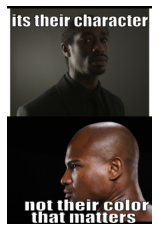

its their character not their color that matters


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
index_of_data = 0
plt.imshow(images[index_of_data])
plt.axis("off")
plt.show()
print(train_samples_frame.loc[index_of_data, "text"])
#model.classify(images[7],train_samples_frame.loc[7, "text"])

In [6]:
def show_image_and_text(index_of_data):
    try:
        print(index_of_data)
        finale_name = "img/" + str(index_of_data) + ".png"
        print(finale_name)
        plt.imshow(Image.open(
            img_path / finale_name
        ).convert("RGB"))
        plt.axis("off")
        plt.show()
    except:
        print("can't show image")

In [7]:
import matplotlib.pyplot as plt
import requests
from mmf.utils.build import (
    build_model, build_processors
)

from PIL import Image

from mmf.models.vilbert import ViLBERTBase
from vilbert_with_tokens import ViLBERTWithTokens
from transformers import BertConfig
from omegaconf import OmegaConf


model_cls = registry.get_model_class("vilbert")
#model = model_cls.from_pretrained("vilbert.finetuned.hateful_memes.direct")
model = model_cls.from_pretrained("vilbert.pretrained.cc.original")
model.build()
#config = load_yaml("../mmf/mmf/configs/models/vilbert/defaults.yaml")
#print(config)
#model = build_model(config.model_name)

#vilbert_config = load_yaml("../mmf/mmf/configs/models/vilbert/defaults.yaml")
#print("**********************")
#print(vilbert_config)
#vilbert_config.model_config.vilbert.training_head_type = "classification"
#print("*************************")
#model = ViLBERTBase.from_pretrained(vilbert_config.model_config.vilbert.bert_model_name, \
#                                        config=BertConfig.from_dict(OmegaConf.to_container(vilbert_config.model_config.vilbert, resolve=True)))
#mmf_model_csl = registry.get_model_class("mmf_transformer")
#mmf_model = mmf_model_csl.from_pretrained("mmf_transformer")
#mmf_model.build()

#processor_dict = build_processors(config.dataset_config.hateful_memes.processors)

#model = ViLBERTWithTokens.from_pretrained("vilbert.finetuned.hateful_memes.direct")
#config = get_config("../mmf/projects/vilbert/configs/hateful_memes/defaults.yaml")
#model = build_model(config.model_config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing ViLBERTBase: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing ViLBERTBase from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing ViLBERTBase from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViLBERTBase were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.v_embeddings.image_embeddings.weight', 'bert.v_embeddings.image_embeddings.bias', 'bert.v_embeddings.image_location_embeddings.weight', 'bert.v_embeddings.image_location_embeddings.bias', 'bert.v_embeddings.LayerNorm.weight', 'bert.v_embeddings.LayerNorm.

Missing keys ['model.bert.embeddings.position_ids', 'model.cls.predictions.bias', 'model.cls.predictions.transform.dense.weight', 'model.cls.predictions.transform.dense.bias', 'model.cls.predictions.transform.LayerNorm.weight', 'model.cls.predictions.transform.LayerNorm.bias', 'model.cls.predictions.decoder.weight', 'model.cls.predictions.decoder.bias', 'model.cls.bi_seq_relationship.weight', 'model.cls.bi_seq_relationship.bias', 'model.cls.imagePredictions.transform.dense.weight', 'model.cls.imagePredictions.transform.dense.bias', 'model.cls.imagePredictions.transform.LayerNorm.weight', 'model.cls.imagePredictions.transform.LayerNorm.bias', 'model.cls.imagePredictions.decoder.weight', 'model.cls.imagePredictions.decoder.bias'] in the checkpoint.
If this is not your checkpoint, please open up an issue on MMF GitHub. 
Unexpected keys if any: ['model.classifier.0.dense.weight', 'model.classifier.0.dense.bias', 'model.classifier.0.LayerNorm.weight', 'model.classifier.0.LayerNorm.bias', 'm

In [8]:
from transformers.tokenization_auto import AutoTokenizer

from mmf.utils.build import (
    build_dataloader_and_sampler
)
model.eval()
cuda = torch.cuda.is_available()
if cuda:
    model = model.cuda(0)


#config = get_config("../mmf/projects/vilbert/configs/hateful_memes/defaults.yaml")
# Load pre-trained model tokenizer (vocabulary)
bert_model_version = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(bert_model_version)
dataset_config.training.num_workers = 0
dataset_config.training.batch_size = 1
dataloader, sampler = build_dataloader_and_sampler(dataset, dataset_config.training)

def tokenize_batch(batch):
    return [tokenizer.convert_tokens_to_ids(sent)+[0]*(128-len(sent)) for sent in batch]

def tokenize_mask_batch(batch, keep_first = 0):
    return [[1]*(keep_first+1) + [0]*(len(sent)-1 - keep_first) for sent in batch]


def untokenize_batch(batch):
    return [tokenizer.convert_ids_to_tokens(sent) for sent in batch]

def detokenize(sent):
    """ Roughly detokenizes (mainly undoes wordpiece) """
    new_sent = []
    print(sent)
    for i, tok in enumerate(sent):
        if tok.startswith("##"):
            if i != 0:
                new_sent[len(new_sent) - 1] = new_sent[len(new_sent) - 1] + tok[2:]
            else:
                new_sent.append(tok[2:])    
        else:
            new_sent.append(tok)
    return new_sent

CLS = '[CLS]'
SEP = '[SEP]'
MASK = '[MASK]'
mask_id = tokenizer.convert_tokens_to_ids([MASK])[0]
sep_id = tokenizer.convert_tokens_to_ids([SEP])[0]
cls_id = tokenizer.convert_tokens_to_ids([CLS])[0]
print(mask_id)
print(sep_id)
print(cls_id)

103
102
101


In [9]:
def generate_step(out, gen_idx, temperature=None, top_k=0, sample=False, return_list=True):
    """ Generate a word from from out[gen_idx]
    
    args:
        - out (torch.Tensor): tensor of logits of size batch_size x seq_len x vocab_size
        - gen_idx (int): location for which to generate for
        - top_k (int): if >0, only sample from the top k most probable words
        - sample (Bool): if True, sample from full distribution. Overridden by top_k 
    """
   # print(top_k)
   # print(sample)
   # print(return_list)
   # print(out.shape)
    #print(gen_idx)
    logits = out[:, gen_idx]
    if temperature is not None:
        logits = logits / temperature
    if top_k > 0:
        kth_vals, kth_idx = logits.topk(top_k, dim=-1)
   #     print(kth_vals)
   #     print(kth_idx)
        dist = torch.distributions.categorical.Categorical(logits=kth_vals)
        idx = kth_idx.gather(dim=1, index=dist.sample().unsqueeze(-1)).squeeze(-1)
    elif sample:        
        dist = torch.distributions.categorical.Categorical(logits=logits)
        idx = dist.sample().squeeze(-1)
    else:
        idx = torch.argmax(logits, dim=-1)
  #  print(idx.type)
  #  print(idx)   
    return idx.tolist()[0] if top_k > 0 else idx

In [10]:
# Generation modes as functions
import math
import time
import tqdm

def get_init_text(seed_text, max_len, batch_size = 1):
    """ Get initial sentence by padding seed_text with masks  """
    batch = [seed_text + [MASK] * max_len + [SEP] for _ in range(batch_size)]   
    return tokenize_batch(batch)

def parallel_sequential_generation(original_batch, seed_text, max_len=15, top_k=0, temperature=None, max_iter=300, burnin=200,
                                   cuda=False, print_every=10, verbose=True):
    """ Generate for one random position at a timestep
    
    args:
        - burnin: during burn-in period, sample from full distribution; afterwards take argmax
    """
    seed_len = len(seed_text)
    
    print("batch_size: ") 
    prepared_batch = dataset.prepare_batch(original_batch)
    print(prepared_batch.get_batch_size())
    batch_size = prepared_batch.get_batch_size()
    print(prepared_batch.fields())
    init_text_ids = get_init_text(seed_text, max_len, batch_size)
    print(init_text_ids)
    print("text_before:")
    print(prepared_batch.get_field("text"))
    print("input ids before:")
    print(prepared_batch.get_field("input_ids"))
    print("msk ids before:")
    print(prepared_batch.get_field("input_mask"))

    
    text_inp = torch.tensor(init_text_ids)
    #text_mask = torch.tensor(init_mask_ids)
    
    prepared_batch.add_field("input_ids", text_inp)
    #prepared_batch.add_field("input_mask", text_mask)


    for ii in range(max_iter):
        kk = np.random.randint(0, max_len)
        for jj in range(batch_size):
            prepared_batch.get_field("input_ids")[jj][seed_len+kk] = mask_id

  #      print("input ids after:")
   #     print(prepared_batch.get_field("input_ids")) 
    #    print("-----------------------------------------------")
        out = model(prepared_batch)
        state = model.state_dict
        print("now getting image captioning only")
        topk = top_k if (ii >= burnin) else 0
        idxs = generate_step(out['prediction_scores_t'], gen_idx=seed_len+kk, top_k=topk, temperature=temperature, sample=(ii < burnin))
        input_ids_batch = prepared_batch.get_field("input_ids").numpy()
        print(input_ids_batch)

        for jj in range(batch_size):
            input_ids_batch[jj][seed_len+kk] = idxs#[jj]

        prepared_batch.add_field("input_ids", torch.from_numpy(input_ids_batch))

        if verbose and np.mod(ii+1, print_every) == 0:
            for_print = tokenizer.convert_ids_to_tokens(prepared_batch.get_field("input_ids").numpy()[0])
            for_print = for_print[:seed_len+kk+1] + ['(*)'] + for_print[seed_len+kk+1:]
            print("iter", ii+1, " ".join(for_print))
    return untokenize_batch(prepared_batch.get_field("input_ids"))    

def parallel_generation(seed_text, max_len=15, top_k=0, temperature=None, max_iter=300, sample=True, 
                        cuda=False, print_every=10, verbose=True):
    """ Generate for all positions at a time step """
    seed_len = len(seed_text)
    batch = get_init_text(seed_text, max_len, batch_size)
    
    for ii in range(max_iter):
        inp = torch.tensor(batch).cuda() if cuda else torch.tensor(batch)
        out = model(inp)
        for kk in range(max_len):
            idxs = generate_step(out, gen_idx=seed_len+kk, top_k=top_k, temperature=temperature, sample=sample)
            for jj in range(batch_size):
                batch[jj][seed_len+kk] = idxs#[jj]
            
        if verbose and np.mod(ii, print_every) == 0:
            print("iter", ii+1, " ".join(tokenizer.convert_ids_to_tokens(batch[0])))
    
    return untokenize_batch(batch)
            
def sequential_generation(original_batch, seed_text, batch_size=2, max_len=15, leed_out_len=15, 
                          top_k=0, temperature=None, sample=True, cuda=False, keep_first=0):
    """ Generate one word at a time, in L->R order """
    seed_len = len(seed_text)
    
    prepared_batch = dataset.prepare_batch(original_batch)
    batch_size = prepared_batch.get_batch_size()
    init_text_ids = get_init_text(seed_text, max_len, batch_size)
    masks = tokenize_mask_batch(init_text_ids, keep_first)
    print("masks:")
    print(masks)
    print("id:")
    print(prepared_batch.get_field("id"))
    show_image_and_text(prepared_batch.get_field("id")[0].item())
    print("fields:")
    print(prepared_batch.fields())
    print("targets:")
    print(prepared_batch.get_field("targets"))
    print("text_before:")
    print(prepared_batch.get_field("text"))
    print("input ids before:")
    print(prepared_batch.get_field("input_ids"))
    print(untokenize_batch(prepared_batch.get_field("input_ids")))
    print("input mask before:")
    print(prepared_batch.get_field("input_mask"))
    
    print(init_text_ids)
    res = []
    
    for keep in range(keep_first):
        init_text_ids = get_init_text(seed_text, max_len, batch_size)
        if keep > 0:
            init_text_ids[0][0:keep+1] = prepared_batch.get_field("input_ids")[0][0:keep+1]
        text_inp = torch.tensor(init_text_ids)
        masks_inp = torch.tensor(masks)

        prepared_batch.add_field("input_ids", text_inp)
        #prepared_batch.add_field("input_mask", masks_inp)
        print("input ids after:")
        print(prepared_batch.get_field("input_ids")) 
        print("input mask after:")
        print(prepared_batch.get_field("input_mask"))
        print("-----------------------------------------------")


        for ii in range(max_len-keep_first):
            before = prepared_batch.get_field("input_ids")
            before[0][seed_len+ii+leed_out_len] = sep_id
            #print(prepared_batch.get_field("input_ids")) 
            out = model(prepared_batch)
            idxs = generate_step(out['prediction_scores_t'], gen_idx=seed_len+ii+keep, top_k=top_k, temperature=temperature, sample=sample)
            for jj in range(batch_size):
                prepared_batch.get_field("input_ids")[jj][seed_len+ii+keep] = idxs
                #prepared_batch.get_field("input_mask")[jj][seed_len+ii+keep_first - 1] = 1
        res += untokenize_batch(prepared_batch.get_field("input_ids"))       

    return res


def generate(n_samples, seed_text="[CLS]", batch_size=1, max_len=25, 
             sample=True, top_k=100, temperature=1.0, burnin=200, max_iter=500,
             cuda=False, print_every=1, keep_first=0):
    # main generation function to call
    sentences = []
    start_time = time.time()
    batch_n = 0
    for original_batch in tqdm.tqdm(dataloader):
        #batch = parallel_sequential_generation(original_batch, seed_text, max_len=max_len, top_k=top_k,
        #                                       temperature=temperature, burnin=burnin, max_iter=max_iter, 
        #                                       cuda=cuda, verbose=True)
        
        batch_res = sequential_generation(original_batch, seed_text, batch_size=1, max_len=max_len, top_k=top_k, temperature=temperature, leed_out_len=leed_out_len, sample=sample, keep_first=keep_first)
        #batch = parallel_generation(seed_text, max_len=max_len, top_k=top_k, temperature=temperature, sample=sample, max_iter=max_iter, cuda=cuda)
        
        if (batch_n + 1) % print_every == 0:
            print("Finished batch %d in %.3fs" % (batch_n + 1, time.time() - start_time))
            start_time = time.time()
        batch_n += 1
        for batch in batch_res:
            sentences += batch
            print("result:")
            print(detokenize(batch[0][1:-1]))
        if batch_n > 5:
            break
    return sentences

In [11]:

def printer(sent, should_detokenize=True):
    if should_detokenize:
        sent = detokenize(sent)[1:-1]
    print(" ".join(sent))
    
def read_sents(in_file, should_detokenize=False):
    sents = [sent.strip().split() for sent in open(in_file).readlines()]
    if should_detokenize:
        sents = [detokenize(sent) for sent in sents]
    return sents

def write_sents(out_file, sents, should_detokenize=False):
    with open(out_file, "w") as out_fh:
        for sent in sents:
            sent = detokenize(sent[1:-1]) if should_detokenize else sent
            out_fh.write("%s\n" % " ".join(sent))

  0%|          | 0/8500 [00:00<?, ?it/s]

masks:
[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
id:
tensor([59682], dtype=torch.int32)
59682
img/59682.png


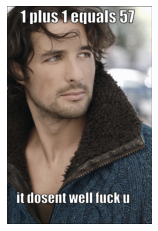

fields:
['text', 'input_ids', 'input_mask', 'segment_ids', 'lm_label_ids', 'tokens', 'id', 'image_feature_0', 'image_info_0', 'targets', 'dataset_name', 'dataset_type']
targets:
tensor([0])
text_before:
[['[CLS]', '1', 'plus', '1', 'equals', '57', 'it', 'dose', '##nt', 'well', 'fuck', 'u', '[SEP]']]
input ids before:
tensor([[  101,  1015,  4606,  1015, 19635,  5401,  2009, 13004,  3372,  2092,
          6616,  1057,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0

input ids after:
tensor([[  101, 24632,  9793, 27385, 22054,   103,   103,   103,   103,   103,
           103,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0

  0%|          | 1/8500 [00:18<43:15:00, 18.32s/it]

Finished batch 1 in 18.323s
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
masks:
[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
id:
tensor([98134], dtype=torch.int32)
98134
img/98134.png


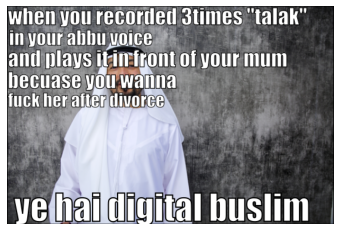

fields:
['text', 'input_ids', 'input_mask', 'segment_ids', 'lm_label_ids', 'tokens', 'id', 'image_feature_0', 'image_info_0', 'targets', 'dataset_name', 'dataset_type']
targets:
tensor([1])
text_before:
[['[CLS]', 'when', 'you', 'recorded', '3', '##time', '##s', '"', 'tal', '##ak', '"', 'in', 'your', 'ab', '##bu', 'voice', 'and', 'plays', 'it', 'in', 'front', 'of', 'your', 'mum', 'be', '##cu', '##ase', 'you', 'wanna', 'fuck', 'her', 'after', 'divorce', 'ye', 'hai', 'digital', 'bus', '##lim', '[SEP]']]
input ids before:
tensor([[  101,  2043,  2017,  2680,  1017,  7292,  2015,  1000, 21368,  4817,
          1000,  1999,  2115, 11113,  8569,  2376,  1998,  3248,  2009,  1999,
          2392,  1997,  2115, 12954,  2022, 10841, 11022,  2017, 10587,  6616,
          2014,  2044,  8179,  6300, 15030,  3617,  3902, 17960,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
 

input ids after:
tensor([[  101, 19527,  7661,  7739, 17468,   103,   103,   103,   103,   103,
           103,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0

  0%|          | 2/8500 [00:36<42:49:59, 18.15s/it]

Finished batch 2 in 17.735s
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
masks:
[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
id:
tensor([92851], dtype=torch.int32)
92851
img/92851.png


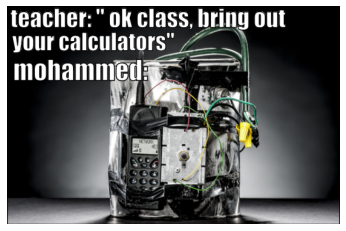

fields:
['text', 'input_ids', 'input_mask', 'segment_ids', 'lm_label_ids', 'tokens', 'id', 'image_feature_0', 'image_info_0', 'targets', 'dataset_name', 'dataset_type']
targets:
tensor([1])
text_before:
[['[CLS]', 'teacher', ':', '"', 'ok', 'class', ',', 'bring', 'out', 'your', 'cal', '##cula', '##tors', '"', 'mohammed', ':', '[SEP]']]
input ids before:
tensor([[  101,  3836,  1024,  1000,  7929,  2465,  1010,  3288,  2041,  2115,
         10250, 19879,  6591,  1000, 12619,  1024,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            

input ids after:
tensor([[  101, 15127, 15526, 10934, 28896,   103,   103,   103,   103,   103,
           103,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0

  0%|          | 3/8500 [00:53<42:08:45, 17.86s/it]

Finished batch 3 in 17.184s
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
masks:
[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
id:
tensor([67481], dtype=torch.int32)
67481
img/67481.png


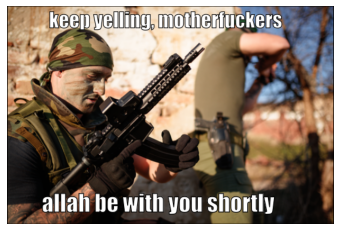

fields:
['text', 'input_ids', 'input_mask', 'segment_ids', 'lm_label_ids', 'tokens', 'id', 'image_feature_0', 'image_info_0', 'targets', 'dataset_name', 'dataset_type']
targets:
tensor([1])
text_before:
[['[CLS]', 'keep', 'yelling', ',', 'mother', '##fu', '##cker', '##s', 'allah', 'be', 'with', 'you', 'shortly', '[SEP]']]
input ids before:
tensor([[  101,  2562, 13175,  1010,  2388, 11263,  9102,  2015, 16455,  2022,
          2007,  2017,  3859,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,    

input ids after:
tensor([[  101,  9813, 28974, 25022, 24558,   103,   103,   103,   103,   103,
           103,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0

  0%|          | 4/8500 [01:10<42:00:02, 17.80s/it]

Finished batch 4 in 17.658s
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
masks:
[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
id:
tensor([14397], dtype=torch.int32)
14397
img/14397.png


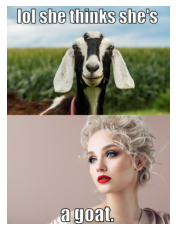

fields:
['text', 'input_ids', 'input_mask', 'segment_ids', 'lm_label_ids', 'tokens', 'id', 'image_feature_0', 'image_info_0', 'targets', 'dataset_name', 'dataset_type']
targets:
tensor([0])
text_before:
[['[CLS]', 'lo', '##l', 'she', 'thinks', 'she', "'", 's', 'a', 'goat', '[SEP]']]
input ids before:
tensor([[  101,  8840,  2140,  2016,  6732,  2016,  1005,  1055,  1037, 13555,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,  

input ids after:
tensor([[  101, 22491, 16150, 13861,  5647,   103,   103,   103,   103,   103,
           103,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0

  0%|          | 5/8500 [01:27<41:04:33, 17.41s/it]

Finished batch 5 in 16.497s
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
masks:
[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
id:
tensor([43905], dtype=torch.int32)
43905
img/43905.png


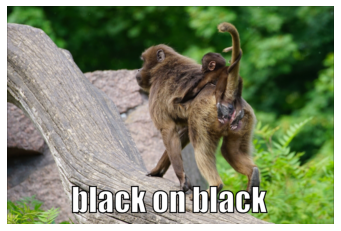

fields:
['text', 'input_ids', 'input_mask', 'segment_ids', 'lm_label_ids', 'tokens', 'id', 'image_feature_0', 'image_info_0', 'targets', 'dataset_name', 'dataset_type']
targets:
tensor([1])
text_before:
[['[CLS]', 'black', 'on', 'black', '[SEP]']]
input ids before:
tensor([[ 101, 2304, 2006, 2304,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

input ids after:
tensor([[  101, 18952, 13141,  2132, 13864,   103,   103,   103,   103,   103,
           103,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0

  0%|          | 5/8500 [01:44<49:05:24, 20.80s/it]

Finished batch 6 in 16.620s
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
result:
CLS
['C', 'L', 'S']
CLS
alenti
ove
ustic
natc
oll
SEP
SEP
SEP
SEP
SEP
SEP
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
CLS
alenti
#ci
ric
pin
ontracto

SEP
SEP
SEP
SEP
SEP
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
P

PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
CLS
escendin
olonist
essi
accine
#
#ogeni
partment
et
evill
SEP
SEP
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
CLS
tage

scendin
olonist
tage
SEP
SEP
SEP
SEP
SEP
SEP
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
PAD
P

In [12]:
n_samples = 1000
batch_size = 1
max_len = 10
top_k = 100
temperature = 0.7

leed_out_len = 5 # max_len
burnin = 250
sample = True
max_iter = 500
registry.register("current_device", torch.device('cuda'))

# Choose the prefix context
seed_text = "[CLS]".split()

with torch.no_grad():
    for temp in [1.0]:
        model_version = "v2"
        bert_sents = generate(n_samples, seed_text=seed_text, batch_size=batch_size, max_len=max_len,
                              sample=sample, top_k=top_k, temperature=temp, burnin=burnin, max_iter=max_iter,
                              cuda=True, keep_first=0)
        out_file = "data/%s-len%d-burnin%d-topk%d-temp%.3f.txt" % (model_version, max_len, burnin, top_k, temp)
        write_sents(out_file, bert_sents, should_detokenize=True)

In [13]:
tokenizer.convert_ids_to_tokens(24908)

'diversified'